In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
from sqlalchemy.exc import ProgrammingError
import json
import folium
import koreanize_matplotlib
from IPython.display import display
from scipy.stats import pearsonr, spearmanr

plt.rcParams["axes.unicode_minus"] = False


In [2]:
load_dotenv()

DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise RuntimeError("환경변수 DB_URL이 없습니다.")

engine = create_engine(DB_URL, future=True, pool_pre_ping=True)

with engine.connect() as conn:
    print("DB 연결 OK:", conn.execute(text("SELECT 1")).scalar_one() == 1)


DB 연결 OK: True


In [3]:
stmts = [

    # 1) 상권별 총매출(평일+주말 합)
    """
    CREATE OR REPLACE VIEW v_sales_area AS
    SELECT
      sc.year_quarter,
      sc.commercial_area_code,
      SUM(sd.sales) AS total_sales
    FROM Shop_Count sc
    JOIN Sales_Daytype sd ON sd.store_id = sc.id
    GROUP BY sc.year_quarter, sc.commercial_area_code
    """,

    # 2) 상권별 소득/지출 (Income = 동 단위 → 상권의 dong_code로 매핑)
    """
    CREATE OR REPLACE VIEW v_income_area AS
    SELECT
      i.year_quarter,
      ca.code AS commercial_area_code,
      i.monthly_income_avg,
      i.food_expenditure,
      i.total_expenditure
    FROM Commercial_Area ca
    JOIN Income i
      ON i.dong_code = ca.dong_code
    """,

    # 3) 개·폐업/경쟁강도(분기×상권)
    """
    CREATE OR REPLACE VIEW v_openclose_comp AS
    SELECT
      year_quarter,
      commercial_area_code,
      AVG(opened_percent)  AS opened_pct,
      SUM(opened_count)    AS opened_cnt,
      AVG(closed_percent)  AS closed_pct,
      SUM(closed_count)    AS closed_cnt,
      SUM(shop_count)      AS shop_cnt,
      SUM(similar_shop_count) AS similar_shop_cnt
    FROM Shop_Count
    GROUP BY year_quarter, commercial_area_code
    """,

    # 4) 유동인구(분기×상권)
    """
    CREATE OR REPLACE VIEW v_fpop_area AS
    SELECT
      year_quarter,
      commercial_area_code,
      total_pop
    FROM Floating_Population
    GROUP BY year_quarter, commercial_area_code, total_pop
    """,

    # 5) 최종 통합 뷰: 동일 분기 기준으로 조인
    """
    CREATE OR REPLACE VIEW v_area_join AS
    SELECT
      ca.code AS commercial_area_code,
      ca.name AS area_name,
      ca.gu,
      ca.dong,
      ca.lon,
      ca.lat,
      s.year_quarter,
      s.total_sales,
      inc.monthly_income_avg,
      inc.food_expenditure,
      oc.opened_pct,
      oc.closed_pct,
      oc.shop_cnt,
      oc.similar_shop_cnt,
      fp.total_pop
    FROM Commercial_Area ca
    LEFT JOIN v_sales_area s
      ON s.commercial_area_code = ca.code
    LEFT JOIN v_income_area inc
      ON inc.commercial_area_code = ca.code
     AND inc.year_quarter = s.year_quarter
    LEFT JOIN v_openclose_comp oc
      ON oc.commercial_area_code = ca.code
     AND oc.year_quarter = s.year_quarter
    LEFT JOIN v_fpop_area fp
      ON fp.commercial_area_code = ca.code
     AND fp.year_quarter = s.year_quarter
    """
]

from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise RuntimeError("환경변수 DB_URL이 없습니다. .env 로드/설정을 확인하세요.")
engine = create_engine(DB_URL, pool_pre_ping=True, future=True)

ok = True
with engine.begin() as conn:
    for i, sql in enumerate(stmts, 1):
        try:
            conn.execute(text(sql))
        except ProgrammingError as e:
            ok = False
            print(f"[ERR] statement #{i} 실패\nSQL:\n{sql}\n\n에러:\n{e}\n", file=sys.stderr)
            break

print("뷰 생성 완료" if ok else "뷰 생성 중 오류 발생")

뷰 생성 완료


In [4]:
with engine.connect() as conn:
    df = pd.read_sql(
        text("""
            SELECT
              year_quarter, commercial_area_code, area_name, gu, dong, lon, lat,
              total_sales, monthly_income_avg, food_expenditure,
              opened_pct, closed_pct, shop_cnt, similar_shop_cnt, total_pop
            FROM v_area_join
        """),
        engine
    )

print(sorted(df['year_quarter'].unique()))
print(df.shape)


[np.float64(20241.0), np.float64(20242.0), np.float64(20243.0), np.float64(20244.0), np.float64(nan)]
(6348, 15)


In [5]:
# 동단위 소득 및 지출 정보 df_dong 저장

sql = """
SELECT
  i.year_quarter,
  i.dong_code,
  d.name  AS dong_name,
  i.monthly_income_avg,
  i.total_expenditure,
  i.food_expenditure
FROM Income i
JOIN Dong d ON d.code = i.dong_code
"""
df_dong = pd.read_sql(text(sql), engine)

df_dong = df_dong.copy()
df_dong["food_share"] = (
    df_dong["food_expenditure"] / df_dong["total_expenditure"]
).where(df_dong["total_expenditure"] > 0)


In [6]:
# 1) 동별 평균(돈 관련 칼럼) 계산
df_avg = (
    df_dong.groupby(["dong_code", "dong_name"], as_index=False)
           .agg(
               monthly_income_avg=("monthly_income_avg", "mean"),
               total_expenditure=("total_expenditure", "mean"),
               food_expenditure=("food_expenditure", "mean"),
           )
)

# 2) 동별 합계로 food_share 계산(∑식비 / ∑총지출)
df_sum = (
    df_dong.groupby(["dong_code", "dong_name"], as_index=False)
           .agg(
               food_exp_sum=("food_expenditure", "sum"),
               total_exp_sum=("total_expenditure", "sum"),
           )
)

# 3) 합쳐서 비율 컬럼 만들기 (0 또는 NaN 방지)
df_avg = df_avg.merge(df_sum, on=["dong_code", "dong_name"], how="left")
df_avg["food_share"] = (df_avg["food_exp_sum"] / df_avg["total_exp_sum"])\
    .where(df_avg["total_exp_sum"].fillna(0) > 0)

df_avg = df_avg[["dong_code","dong_name",
                 "monthly_income_avg","total_expenditure","food_expenditure","food_share"]]

df_sorted = df_avg.dropna(subset=["monthly_income_avg"])\
                  .sort_values("monthly_income_avg", ascending=False)

top10 = df_sorted.head(10).copy()
bottom10 = df_sorted.sort_values("monthly_income_avg", ascending=True).head(10).copy()

cols = ["dong_code","dong_name","monthly_income_avg","total_expenditure","food_expenditure","food_share"]

fmt_money = {"monthly_income_avg": "{:,.0f}",
             "food_expenditure": "{:,.0f}",
             "total_expenditure": "{:,.0f}"}
fmt_ratio = {"food_share": "{:.1%}"}

print("월평균소득 상위 10개 동(2024년 4개 분기 평균)")
display(
    top10[cols].reset_index(drop=True)
        .style.format({**fmt_money, **fmt_ratio})
        .set_properties(subset=["dong_name"], **{"font-weight": "bold"})
)

print("월평균소득 하위 10개 동(2024년 4개 분기 평균)")
display(
    bottom10[cols].reset_index(drop=True)
        .style.format({**fmt_money, **fmt_ratio})
        .set_properties(subset=["dong_name"], **{"font-weight": "bold"})
)


월평균소득 상위 10개 동(2024년 4개 분기 평균)


,dong_code,dong_name,monthly_income_avg,total_expenditure,food_expenditure,food_share
0,11680600,대치1동,"7,421,305","9,642,807,500","824,598,250",8.6%
1,11650570,반포2동,"6,812,331","1,331,969,250","377,513,750",28.3%
2,11680656,도곡2동,"6,567,504","45,774,475,500","1,811,283,250",4.0%
3,11650531,서초4동,"6,475,383","23,157,606,500","4,076,142,000",17.6%
4,11710670,잠실2동,"6,352,641","2,414,393,750","278,851,000",11.5%
5,11650580,반포3동,"6,140,775","3,449,867,500","745,523,000",21.6%
6,11710566,오륜동,"6,095,160","1,751,522,250","409,882,750",23.4%
7,11680610,대치2동,"6,017,362","21,305,326,000","2,269,050,250",10.7%
8,11710720,잠실7동,"6,014,516","297,012,750","30,108,500",10.1%
9,11710690,잠실4동,"6,007,987","1,182,647,250","153,403,250",13.0%


월평균소득 하위 10개 동(2024년 4개 분기 평균)


,dong_code,dong_name,monthly_income_avg,total_expenditure,food_expenditure,food_share
0,11320700,방학2동,"2,099,146","1,669,212,000","293,585,250",17.6%
1,11110680,창신2동,"2,112,817","801,160,250","350,083,000",43.7%
2,11470580,신월3동,"2,152,244","1,743,706,500","217,705,750",12.5%
3,11305635,수유3동,"2,205,999","7,745,705,250","2,987,702,000",38.6%
4,11305615,수유1동,"2,220,463","3,165,424,000","583,062,750",18.4%
5,11470560,신월1동,"2,227,154","2,606,313,000","552,148,500",21.2%
6,11320513,창3동,"2,229,423","951,831,250","322,790,000",33.9%
7,11260660,망우3동,"2,231,082","1,175,107,250","244,661,250",20.8%
8,11290760,장위1동,"2,231,978","1,097,677,500","281,510,500",25.6%
9,11260550,면목5동,"2,233,073","1,840,501,500","135,536,250",7.4%


In [7]:
# 동 단위 소득/지출 (모든 분기 로드)
sql_dong = """
SELECT
  i.year_quarter,
  i.dong_code,
  d.name  AS dong_name,
  i.monthly_income_avg,
  i.total_expenditure,
  i.food_expenditure
FROM Income i
JOIN Dong d ON d.code = i.dong_code
"""
df_dong_all = pd.read_sql(text(sql_dong), engine)

# 분기 평균 & 총지출 대비 음식지출 비중
df_dong_mean = (
    df_dong_all.groupby(["dong_code", "dong_name"], as_index=False)
      .agg(
          monthly_income_avg=("monthly_income_avg", "mean"),
          total_expenditure=("total_expenditure", "mean"),
          food_expenditure=("food_expenditure", "mean"),
          food_exp_sum=("food_expenditure", "sum"),
          total_exp_sum=("total_expenditure", "sum"),
      )
)
df_dong_mean["food_share"] = (df_dong_mean["food_exp_sum"] / df_dong_mean["total_exp_sum"])\
    .where(df_dong_mean["total_exp_sum"].fillna(0) > 0)

# 중간 합계 컬럼 정리(원래 컬럼만 유지)
df_dong = df_dong_mean[[
    "dong_code","dong_name","monthly_income_avg","total_expenditure","food_expenditure","food_share"
]].copy()

# 동 매출(평일+주말 합)의 분기 평균
sql_sales_by_dong = """
WITH by_q AS (
  SELECT
    s.year_quarter,
    ca.dong_code,
    COUNT(*)           AS area_cnt_q,         -- 분기별 해당 동 상권 수
    AVG(s.total_sales) AS sales_avg_area_q,   -- 분기별 상권 평균 매출
    SUM(s.total_sales) AS sales_sum_area_q    -- 분기별 상권 총매출
  FROM v_sales_area s
  JOIN Commercial_Area ca
    ON ca.code = s.commercial_area_code
  GROUP BY s.year_quarter, ca.dong_code
)
SELECT
  dong_code,
  AVG(area_cnt_q)        AS area_cnt,         -- 분기 평균 상권 수
  AVG(sales_avg_area_q)  AS sales_avg_area,   -- (분기별 상권 평균)의 평균
  AVG(sales_sum_area_q)  AS sales_sum_area    -- (분기별 총매출)의 평균
FROM by_q
GROUP BY dong_code
"""
df_sales_dong = pd.read_sql(text(sql_sales_by_dong), engine)

# 병합 (dong_code 기준)
df_dx = df_dong.merge(df_sales_dong, on="dong_code", how="left")


In [9]:
fmt_money = {
    "monthly_income_avg": "{:,.0f}",
    "total_expenditure": "{:,.0f}",
    "food_expenditure": "{:,.0f}",
    "sales_avg_area": "{:,.0f}",
    "sales_sum_area": "{:,.0f}",
}
fmt_ratio = {"food_share": "{:.1%}"}
fmt_count = {"area_cnt": "{:,.1f}"}

# 소득 상위/하위 10개 동 표 (정렬 기준: monthly_income_avg) — 분기 평균 기준
df_sorted = (
    df_dx.dropna(subset=["monthly_income_avg"])
           .sort_values("monthly_income_avg", ascending=False)
)

top10 = df_sorted.head(20).copy()  # ← 10개로 맞춤
bottom10 = df_sorted.sort_values("monthly_income_avg", ascending=True).head(10).copy()

cols = [
    "dong_code", "dong_name",
    "monthly_income_avg",
    "total_expenditure", "food_expenditure", "food_share",
    "area_cnt", "sales_avg_area", "sales_sum_area",
]

print("소득 상위 10개 동 (분기 평균, 상권 매출 평균/합계 포함)")
display(
    top10[cols].reset_index(drop=True)
        .style.format({**fmt_money, **fmt_ratio, **fmt_count})
        .set_properties(subset=["dong_name"], **{"font-weight": "bold"})
)

print("소득 하위 10개 동 (분기 평균, 상권 매출 평균/합계 포함)")
display(
    bottom10[cols].reset_index(drop=True)
        .style.format({**fmt_money, **fmt_ratio, **fmt_count})
        .set_properties(subset=["dong_name"], **{"font-weight": "bold"})
)


소득 상위 10개 동 (분기 평균, 상권 매출 평균/합계 포함)


,dong_code,dong_name,monthly_income_avg,total_expenditure,food_expenditure,food_share,area_cnt,sales_avg_area,sales_sum_area
0,11680600,대치1동,"7,421,305","9,642,807,500","824,598,250",8.6%,1.0,"64,412,429,842","64,412,429,842"
1,11650570,반포2동,"6,812,331","1,331,969,250","377,513,750",28.3%,nan,nan,nan
2,11680656,도곡2동,"6,567,504","45,774,475,500","1,811,283,250",4.0%,2.0,"15,599,519,504","31,199,039,008"
3,11650531,서초4동,"6,475,383","23,157,606,500","4,076,142,000",17.6%,nan,nan,nan
4,11710670,잠실2동,"6,352,641","2,414,393,750","278,851,000",11.5%,nan,nan,nan
5,11650580,반포3동,"6,140,775","3,449,867,500","745,523,000",21.6%,nan,nan,nan
6,11710566,오륜동,"6,095,160","1,751,522,250","409,882,750",23.4%,nan,nan,nan
7,11680610,대치2동,"6,017,362","21,305,326,000","2,269,050,250",10.7%,3.0,"61,775,988,273","185,327,964,820"
8,11710720,잠실7동,"6,014,516","297,012,750","30,108,500",10.1%,nan,nan,nan
9,11710690,잠실4동,"6,007,987","1,182,647,250","153,403,250",13.0%,1.0,"7,649,378,402","7,649,378,402"


소득 하위 10개 동 (분기 평균, 상권 매출 평균/합계 포함)


,dong_code,dong_name,monthly_income_avg,total_expenditure,food_expenditure,food_share,area_cnt,sales_avg_area,sales_sum_area
0,11320700,방학2동,"2,099,146","1,669,212,000","293,585,250",17.6%,4.0,"7,057,958,613","28,231,834,452"
1,11110680,창신2동,"2,112,817","801,160,250","350,083,000",43.7%,2.0,"4,292,287,178","8,584,574,357"
2,11470580,신월3동,"2,152,244","1,743,706,500","217,705,750",12.5%,4.0,"2,051,226,467","8,204,905,869"
3,11305635,수유3동,"2,205,999","7,745,705,250","2,987,702,000",38.6%,8.0,"17,135,443,139","137,083,545,110"
4,11305615,수유1동,"2,220,463","3,165,424,000","583,062,750",18.4%,7.0,"6,021,516,970","42,150,618,787"
5,11470560,신월1동,"2,227,154","2,606,313,000","552,148,500",21.2%,6.0,"4,200,783,565","25,204,701,388"
6,11320513,창3동,"2,229,423","951,831,250","322,790,000",33.9%,2.0,"7,785,842,860","15,571,685,720"
7,11260660,망우3동,"2,231,082","1,175,107,250","244,661,250",20.8%,2.0,"1,310,029,510","2,620,059,020"
8,11290760,장위1동,"2,231,978","1,097,677,500","281,510,500",25.6%,3.2,"1,515,628,840","4,826,429,440"
9,11260550,면목5동,"2,233,073","1,840,501,500","135,536,250",7.4%,2.0,"4,199,981,510","8,399,963,021"


-> 고소득 지역에 상권이 부재하는 경우가 있어서 20개로 출력 늘림
고소득 지역이 주거 위주로 형성되어 있다는 것을 시사. 

In [26]:
def corr_pair(df, x, y, log=False):
    t = df[[x, y]].dropna().astype(float)
    n = len(t)
    if n < 3:
        return {"pearson": None, "spearman": None, "n": n}

    X = t[x].to_numpy()
    Y = t[y].to_numpy()
    if log:
        X = np.log1p(X)
        Y = np.log1p(Y)

    return {
        "pearson": round(pearsonr(X, Y)[0], 3),
        "spearman": round(spearmanr(X, Y)[0], 3),
        "n": n
    }

# 총매출(sales_sum_area) 쪽은 로그로 본다
pairs_mean_log = [
    ("소득 vs 상권매출(총매출)",       "monthly_income_avg", "sales_sum_area", True),
    ("총지출 vs 상권매출(총매출)",     "total_expenditure",  "sales_sum_area", True),
    ("음식지출 vs 상권매출(총매출)",   "food_expenditure",   "sales_sum_area", True),
    ("지출비중 vs 상권매출(총매출)",   "food_share",         "sales_sum_area", True),
]

print("상관관계 (피어슨/스피어만, 표본수 n)  ※ log1p 적용")
for name, x, y, log_flag in pairs_mean_log:
    c = corr_pair(df_dx, x, y, log=log_flag)
    suf = " (log1p)" if log_flag else ""
    print(f"- {name}{suf}: pearson={c['pearson']}, spearman={c['spearman']}, n={c['n']}")


상관관계 (피어슨/스피어만, 표본수 n)  ※ log1p 적용
- 소득 vs 상권매출(총매출) (log1p): pearson=0.132, spearman=0.119, n=397
- 총지출 vs 상권매출(총매출) (log1p): pearson=0.665, spearman=0.731, n=397
- 음식지출 vs 상권매출(총매출) (log1p): pearson=0.762, spearman=0.763, n=397
- 지출비중 vs 상권매출(총매출) (log1p): pearson=0.032, spearman=0.094, n=397


소득 ↔ 총매출: 상관관계 약함 (r=0.132, ρ=0.119)
동 평균소득은 상권 총매출 설명력이 거의 없음
고소득 동이라도 주거 중심이면 상권 규모가 작을 수 있고, 소비가 다른 동(근무·유흥·관광지)에서 일어날 수 있음.
⇒ 입지/매출 예측 변수로 ‘소득’ 단독은 추천하지 않음

총지출 ↔ 총매출: 강함 (r=0.665, ρ=0.731)
동 단위 총지출 규모가 클수록 상권 총매출도 크다는 강한 단조·준선형 관계
“시장 크기(지갑 총량) ↔ 상권 매출”의 직관과 부합.
⇒ 시장규모 지표(총지출)는 강력한 1차 스크리닝 변수로 유효

음식지출 ↔ 총매출: 매우 강함 (r=0.762, ρ=0.763)
외식/식비 지출이 클수록 상권 매출이 특히 잘 오른다는 신호입니다.
상권 매출에서 F&B 비중이 크다는 구조적 특성을 반영.
⇒ 입지평가·매출모형에서 최우선 핵심 변수로 추천

식비 비중(food_share) ↔ 총매출: 무의미에 가까움 (r=0.032, ρ=0.094)
지출의 ‘구성비’는 총매출과 거의 관련 없음.
고소득·고매출 지역일수록 식비 비중은 약해지는 경향(절대액은 크지만 지출구성에서 비중은 낮아짐).
저소득 지역일수록 엥겔 지수가 높다는 것.
⇒ 비중보다 ‘절대액(음식지출)’을 고려해야 함

-> 비즈니스 시사점
시장규모(총지출) 큰 곳일수록 음식지출 절대액 크게 동반 상승함 → 외식업 상권 잠재력 높음
소득 변수는 직접적 설명력 낮음 → 입지 평가 시 보조 변수로 취급, 총지출·음식지출 중심 설계 권장

In [ ]:
def corr_report(df, x, y):
    
    t = df[[x, y]].dropna().astype(float)
    n = len(t)
    if n < 3:
        print(f"- {x} vs {y}: 표본수 부족(n={n})")
        return
    X, Y = t[x].to_numpy(), t[y].to_numpy()

    # RAW
    p_raw = pearsonr(X, Y)[0]
    s_raw = spearmanr(X, Y)[0]

    # LOG1P
    Xl, Yl = np.log1p(X), np.log1p(Y)
    p_log = pearsonr(Xl, Yl)[0]
    s_log = spearmanr(Xl, Yl)[0]

    print(f"[{x} vs {y}] n={n}")
    print(f"  - Pearson (raw)   : {p_raw:.3f}   | Spearman (raw)   : {s_raw:.3f}")
    print(f"  - Pearson (log1p) : {p_log:.3f}   | Spearman (log1p) : {s_log:.3f}")

# 1) 소득 ↔ 총지출
corr_report(df_dx, "monthly_income_avg", "total_expenditure")

# 2) 총지출 ↔ 음식지출
corr_report(df_dx, "total_expenditure", "food_expenditure")


[monthly_income_avg vs total_expenditure] n=425
  - Pearson (raw)   : 0.146   | Spearman (raw)   : 0.197
  - Pearson (log1p) : 0.237   | Spearman (log1p) : 0.197
[total_expenditure vs food_expenditure] n=425
  - Pearson (raw)   : 0.322   | Spearman (raw)   : 0.911
  - Pearson (log1p) : 0.818   | Spearman (log1p) : 0.911


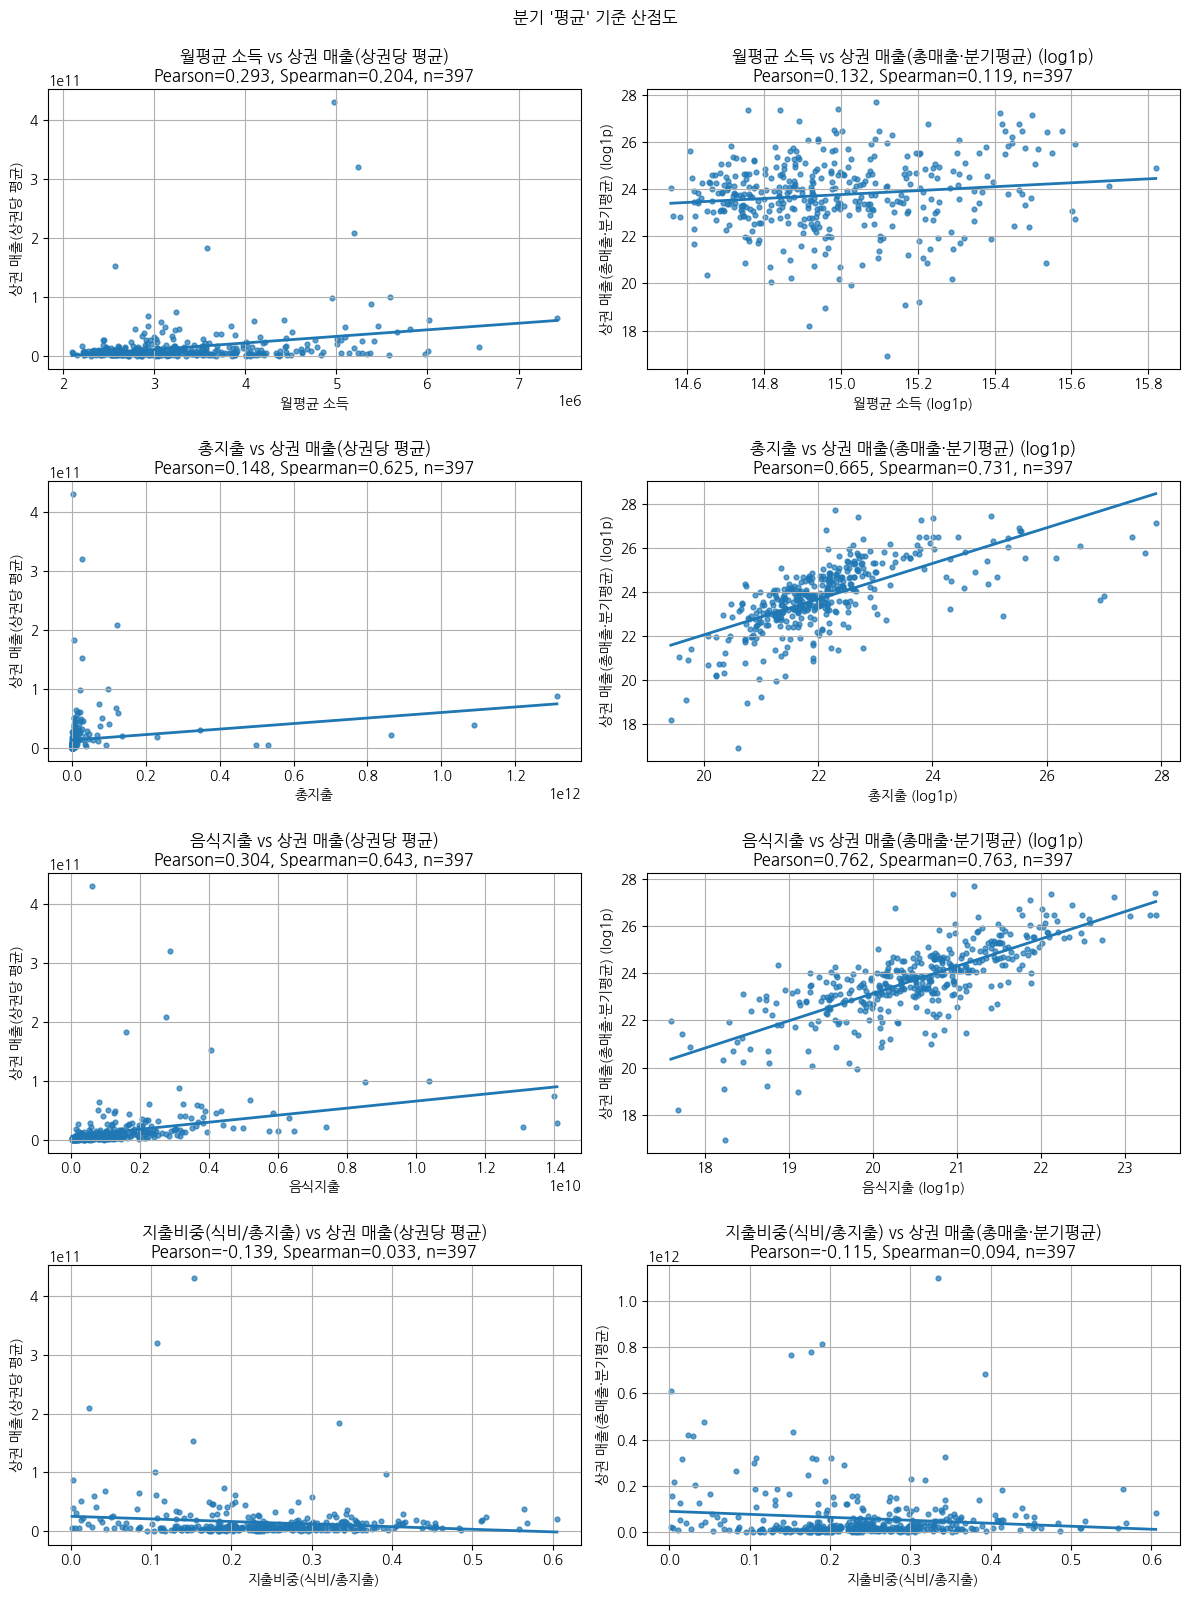

In [27]:
label_map = {
    "monthly_income_avg": "월평균 소득",
    "total_expenditure": "총지출",
    "food_expenditure": "음식지출",
    "food_share": "지출비중(식비/총지출)",
    "sales_avg_area": "상권 매출(상권당 평균)",
    "sales_sum_area": "상권 매출(총매출·분기평균)",
    "sales_sum_area_sum": "상권 매출(총매출·모든분기 합계)",
}

def plot_corr_grid(df, pairs, title="", ncols=2):
    """
    pairs: [(x, y, log_bool), ...]
    2열 그리드로 산점도+회귀선+상관수치 표시
    """
    def _corr_numbers(x, y):
        t = np.array([x, y], dtype=float).T
        t = t[~np.isnan(t).any(axis=1)]
        if len(t) < 3:
            return None, None, len(t)
        return pearsonr(t[:,0], t[:,1])[0], spearmanr(t[:,0], t[:,1])[0], len(t)

    n = len(pairs)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    if nrows * ncols == 1:
        axes = np.array([axes])
    axes = axes.reshape(nrows, ncols).ravel()

    for i, (x, y, log) in enumerate(pairs):
        ax = axes[i]
        t = df[[x, y]].dropna().copy()
        if len(t) < 3:
            ax.axis("off")
            ax.set_title(f"[SKIP] {x} vs {y} (n={len(t)})")
            continue

        X = t[x].values.astype(float)
        Y = t[y].values.astype(float)
        if log:
            Xp = np.log1p(X); Yp = np.log1p(Y); suffix = " (log1p)"
        else:
            Xp, Yp = X, Y;     suffix = ""

        # 상관수치
        p, s, nobs = _corr_numbers(Xp, Yp)

        # 회귀선(단순 직선)
        m, b = np.polyfit(Xp, Yp, 1)
        xsorted = np.sort(Xp)
        ax.scatter(Xp, Yp, s=12, alpha=0.7)
        ax.plot(xsorted, m*xsorted + b, linewidth=2)

        ax.set_title(f"{label_map.get(x, x)} vs {label_map.get(y, y)}{suffix}\n"
                     f"Pearson={p:.3f}, Spearman={s:.3f}, n={nobs}")
        ax.set_xlabel(label_map.get(x, x) + (suffix if log else ""))
        ax.set_ylabel(label_map.get(y, y) + (suffix if log else ""))
        ax.grid(True)

    # 남는 축 숨기기
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    if title:
        fig.suptitle(title, y=0.995)
    fig.tight_layout()
    plt.show()

# 1) 분기 '평균' 기준
pairs_mean_plot = [
    ("monthly_income_avg", "sales_avg_area", False),
    ("monthly_income_avg", "sales_sum_area", True),
    ("total_expenditure",  "sales_avg_area", False),
    ("total_expenditure",  "sales_sum_area", True),
    ("food_expenditure",   "sales_avg_area", False),
    ("food_expenditure",   "sales_sum_area", True),
    ("food_share",         "sales_avg_area", False),
    ("food_share",         "sales_sum_area", False),
]
plot_corr_grid(df_dx, pairs_mean_plot, title="분기 '평균' 기준 산점도", ncols=2)


In [ ]:
df_area_income = pd.read_sql(text("""
SELECT area_name, gu, dong, lon, lat, monthly_income_avg
FROM v_area_join
WHERE year_quarter = :q
  AND lon IS NOT NULL AND lat IS NOT NULL
"""), engine, params={"q": latest})

m = folium.Map(location=[37.5665,126.9780], zoom_start=11)
scale = (df_area_income["monthly_income_avg"]
         .fillna(df_area_income["monthly_income_avg"].median())
         / 100).clip(2, 15)

for (_, r), rad in zip(df_area_income.iterrows(), scale):
    folium.CircleMarker(
        [r.lat, r.lon],
        radius=float(rad),
        tooltip=f"{r.area_name} ({r.gu} {r.dong})\n소득:{r.monthly_income_avg:,.0f}",
        fill=True
    ).add_to(m)

display(m)